In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Projet 2 - Modèles épidémiologiques


### 1) Modelisation système SIR

Le modèle SIR est un modele qui décrit la propagation d'un virus (biologique ou informatique) au sein d'une population homogène. Il divise la population en trois catégories : les susceptibles (S), les infectés (I) et les retirés (R). Les parametes importants sont: le taux de transmission $\beta$ et le taux de guérison $\gamma$.

### Équations du Modèle

Dans le modele SIR, comme vue en cours et dans le poly,les equations sont données par :

$$
S(t)+I(t) +R(t) = N+1
$$

$$
\frac{dS(t)}{dt} = -\beta S(t) I(t),
$$

$$
\frac{dI(t)}{dt} = \beta S(t) I(t) - \gamma I(t),
$$

$$
\frac{dR(t)}{dt} = \gamma I(t),
$$

tel que la population est de taille $N+1$,


Pour simuler ce système, comme en TSE101 dans la partie Lotka Volterra, j'ai utilisé la méthode d'Euler. À chaque itération, les valeurs de $S$, $I$ et $R$ sont mises à jour en fonction des taux de variation calculés.

Voici la fonction qui simule le modèle :

In [ ]:
def sir_model(N_pop, beta, gamma, tps_model, dt):
    S = [N_pop]
    I = [1]
    R = [0]
    t = [0]
    
    # Simulation via methode de Euler
    while t[-1] < tps_model:
        #Met a jour chaque valeur de S,I,R avec l'instant n-1
        dS = -beta * S[-1] * I[-1] / N_pop
        dI = beta * S[-1] * I[-1] / N_pop - gamma * I[-1]
        dR = gamma * I[-1]
        
        #Ajoute toutes les valeurs mise a jour en n + n-1
        S.append(S[-1] + dS * dt)
        I.append(I[-1] + dI * dt)
        R.append(R[-1] + dR * dt)
        t.append(t[-1] + dt)
    
    return np.array(t), np.array(S), np.array(I), np.array(R)

Voici le code qui affiche les résultats pour des paramètres de $\gamma = 10\%$, $\beta = 20\%$, $N = 10^3$. (J'ai pris les meme parametres que [1])

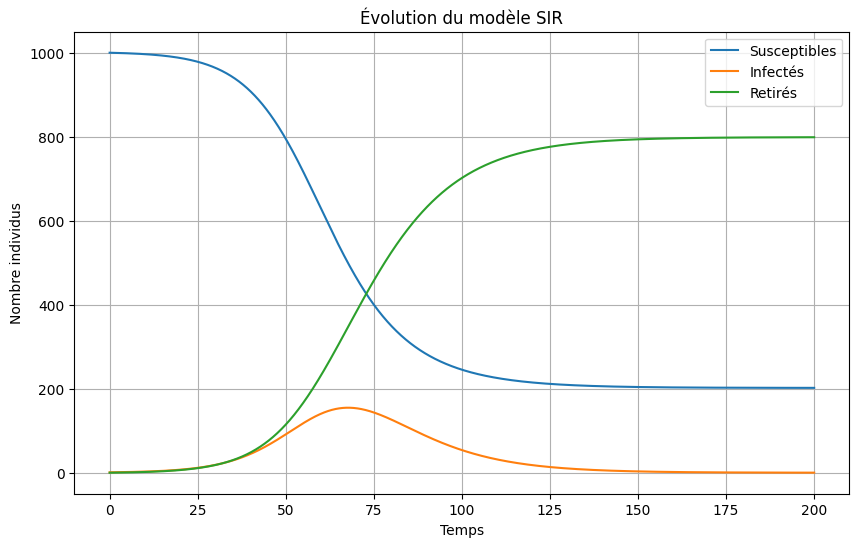

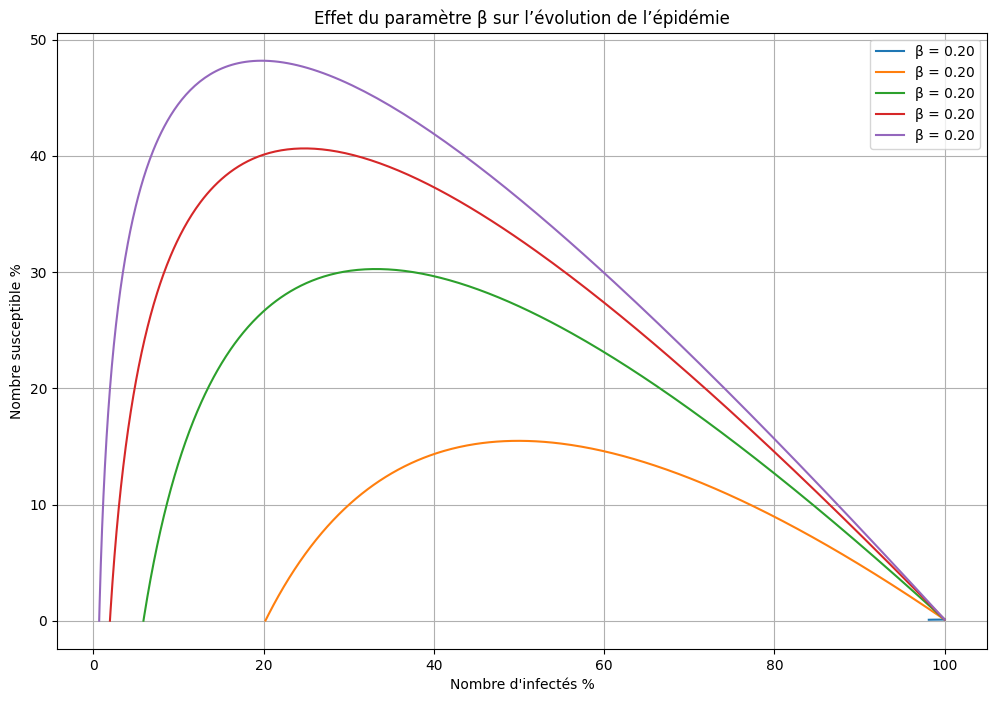

In [ ]:
#Parametre de la simulation
N_pop = 1000      # Valeurs conseiller en cours
beta = 0.2    # 20%
gamma = 0.1   # 10%
tps_model = 200 
dt = 0.1   

t, S, I, R = sir_model(N_pop, beta, gamma, tps_model, dt)

# Plot du graph
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptibles')
plt.plot(t, I, label='Infectés')
plt.plot(t, R, label='Retirés')
plt.xlabel('Temps')
plt.ylabel('Nombre individus')
plt.title('Évolution du modèle SIR')
plt.legend()
plt.grid()
plt.show()

#Je veux voir l'impacte de beta sur la propagation
effet_beta = []
beta_val = np.linspace(0.1, 0.5, 5)

#Boucle sur les valeurs de beta
for i in beta_val:
    t, S, I, R = sir_model(N_pop, i, gamma, tps_model, dt)
    effet_beta.append((beta, t, S, I, R))

#Plot des graphs
plt.figure(figsize=(12,8))
for beta, t, S, I, R in effet_beta:
    plt.plot((S/N_pop)*100, (I/N_pop)*100, label=f"β = {beta:.2f}")
plt.xlabel('Nombre d\'infectés %')
plt.ylabel('Nombre susceptible %')
plt.title('Effet du paramètre β sur l’évolution de l’épidémie')
plt.legend()
plt.grid()
plt.show()




### 2) Modelisation du processus de Markov

Dans ca cas $\beta$ devient le taux de rencontres que ce soit avec des susceptibles, des infectés ou des retirés. <br>
Et on note $X = (S, I, R)$  un processus de Markov tel que :

- $(s,i,r) \rightarrow (s-1,i+1,r)$ au taux $\beta N^{-1} is \mathbb{1}_{s>0}$
- $(s,i,r) \rightarrow (s,i-1,r+1)$ au taux $\gamma i \mathbb{1}_{i>0}$

On note ausse $R_0 = \frac{\beta}{\gamma}$.

In [ ]:
# Simulation du processus de Markov pour le modèle SIR
def sir_markov(N, beta, gamma, t_max):
    S = [N - 1]  # N-1 susceptibles au début
    I = [1]      # 1 infecté initial
    R = [0]      # 0 retiré
    t = [0]

    while t[-1] < t_max and I[-1] > 0:
        s, i, r = S[-1], I[-1], R[-1]

        # Taux d'infection et de guérison
        infection = beta * 1/N * s * i / N if s > 0 else 0
        sortie = gamma * i if i > 0 else 0
        total_rate = infection + sortie

        if total_rate == 0:
            break

        # Tire un temps aleatoire pour le prochain event
        time_step = np.random.exponential(1 / total_rate)
        t.append(t[-1] + time_step)

        # Choix de l'événement
        if np.random.rand() < infection / total_rate:
            # Infection
            if s > 0:
                S.append(s - 1)
                I.append(i + 1)
                R.append(r)
            else:
                # Cas rare mais possible : personne à infecter
                S.append(s)
                I.append(i)
                R.append(r)
        else:
            # Guérison
            if i > 0:
                S.append(s)
                I.append(i - 1)
                R.append(r + 1)
            else:
                # Cas rare mais possible : personne à guérir
                S.append(s)
                I.append(i)
                R.append(r)

    return np.array(t), np.array(S), np.array(I), np.array(R)

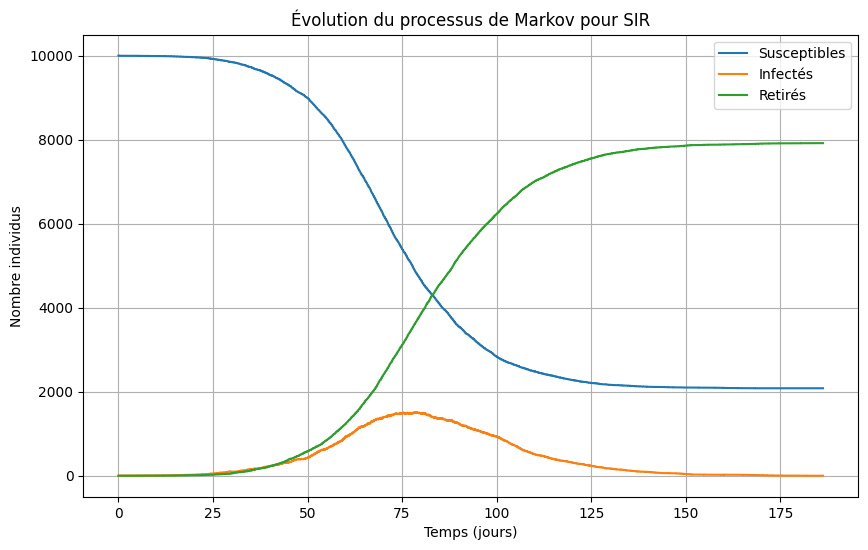

In [26]:
N = 10000     
beta = 0.2    # Taux de transmission
gamma = 0.1   # Taux de guérison
t_max = 200  

# Exécution de la simulation
t, S, I, R = sir_markov(N, beta, gamma, t_max)

# Affichage des résultats
plt.figure(figsize=(10,6))
plt.step(t, S, label='Susceptibles')
plt.step(t, I, label='Infectés')
plt.step(t, R, label='Retirés')
plt.xlabel('Temps (jours)')
plt.ylabel('Nombre individus')
plt.title('Évolution du processus de Markov pour SIR')
plt.legend()
plt.grid()
plt.show()